In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
np.random.seed(1000)
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# Given a stock, remove data of data of all non-trading day
def removeNonTradingDays(df):
    return df[df.index.dayofweek < 5]


# Given a list of stocks, find the common interval (latestStart, earliestEnd) for all the stocks
def commonInterval(tickers):
    latestStart = None
    earliestEnd = None
    for data in tickers:
        if latestStart == None or data.index[0] > latestStart:
            latestStart = data.index[0]
        if earliestEnd == None or data.index[-1] < earliestEnd:
            earliestEnd = data.index[-1]
    return (latestStart, earliestEnd)

<IPython.core.display.Javascript object>

In [4]:
# Load these stocks
stockNames = ["VUSA", "A35", "S59", "VUSD", "BAB", "IWDA", "Z74", "ES3", "VWRD"]
stocks = list(
    map(
        lambda x: removeNonTradingDays(
            pd.read_csv(f"data/{x}.csv", index_col="Date", parse_dates=True)
        ),
        stockNames,
    )
)
commonInterval(stocks)

(Timestamp('2013-06-05 00:00:00'), Timestamp('2019-06-13 00:00:00'))

<IPython.core.display.Javascript object>

In [5]:
(start, end) = commonInterval(stocks)
stocks[0][start:end]
trimmedStocksClosingPrices = list(map(lambda x: x[start:end].Close, stocks))
stocksClosingPrices = pd.concat(trimmedStocksClosingPrices, axis=1, keys=stockNames)
stocksClosingPricesForwardFilled = stocksClosingPrices.fillna(method="ffill")
normalisedClosingPrice = (
    stocksClosingPricesForwardFilled / stocksClosingPricesForwardFilled.iloc[0]
)

<IPython.core.display.Javascript object>

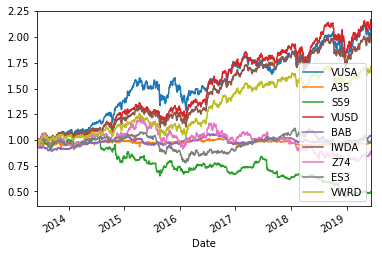

<IPython.core.display.Javascript object>

In [6]:
normalisedClosingPrice.plot()
plt.show()

In [7]:
# Calculate returns of individual assets
returns = np.log(normalisedClosingPrice / normalisedClosingPrice.shift(1))
returns.mean() * 252

VUSA    0.117755
A35    -0.003470
S59    -0.112654
VUSD    0.124928
BAB     0.006447
IWDA    0.113567
Z74    -0.016541
ES3    -0.000297
VWRD    0.086732
dtype: float64

<IPython.core.display.Javascript object>

In [8]:
# Calculate covariance of each asset to another based on trading days
retCov = returns.cov() * 252
retCov

,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD
VUSA,0.022910,-0.000163,0.001959,0.017289,-0.001411,0.015669,0.004886,0.006045,0.015545
A35,-0.000163,0.008888,-0.000044,-0.000119,0.000287,-0.000010,0.000010,-0.000355,0.000096
S59,0.001959,-0.000044,0.024308,0.001098,-0.000249,0.001397,0.004381,0.004504,0.001418
VUSD,0.017289,-0.000119,0.001098,0.020134,-0.000837,0.018173,0.004220,0.004480,0.018043
BAB,-0.001411,0.000287,-0.000249,-0.000837,0.003878,-0.000934,-0.000148,-0.000407,-0.000892
IWDA,0.015669,-0.000010,0.001397,0.018173,-0.000934,0.017489,0.004758,0.005106,0.017408
Z74,0.004886,0.000010,0.004381,0.004220,-0.000148,0.004758,0.025908,0.010228,0.004988
ES3,0.006045,-0.000355,0.004504,0.004480,-0.000407,0.005106,0.010228,0.013702,0.005339
VWRD,0.015545,0.000096,0.001418,0.018043,-0.000892,0.017408,0.004988,0.005339,0.017674


<IPython.core.display.Javascript object>

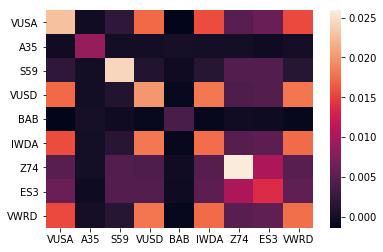

<IPython.core.display.Javascript object>

In [10]:
# retCov["BTC"]["BTC"] = 0
sns.heatmap(retCov)
plt.show()

In [11]:
def randomWeight(length):
    w = np.random.random(length)
    w /= np.sum(w)
    return w


def expectedPortfolioRet(returns, weight):
    return np.sum(returns.mean() * weight) * 252


def expectedPortfolioVar(returns, weight):
    return np.dot(weight, np.dot(returns.cov() * 252, weight))


def expectedSharpeRatio(returns, weight, rf=0):
    return (expectedPortfolioRet(returns, weight) - rf) / expectedPortfolioVar(
        returns, weight
    )

<IPython.core.display.Javascript object>

In [12]:
# Find performance of current portfolio to be used as benchmark
currentWeight = [
    0.08992020522,
    0.2744348384,
    0.03070927321,
    0.01896821775,
    0.06166520726,
    0.06204753154,
    0.02053451402,
    0.3393806347,
    0.102339578,
]

print(f"Sharpe Ratio: {expectedSharpeRatio(returns, currentWeight, 0.02)}")
print(f"Returns: {expectedPortfolioRet(returns, currentWeight)}")
print(f"Volatility: {expectedPortfolioVar(returns, currentWeight)}")

Sharpe Ratio: 0.9192931634423893
Returns: 0.024426103239657028
Volatility: 0.004814680904492993


<IPython.core.display.Javascript object>

In [15]:
noSimulations = 100000
rf = 0.02
simWeights = []
simRets = []
simVols = []
simSharpes = []

for i in range(noSimulations):
    weights = randomWeight(len(stockNames))
    simWeights.append(weights)
    ret = expectedPortfolioRet(returns, weights)
    var = expectedPortfolioVar(returns, weights)
    simRets.append(ret)
    simVols.append(var)
    simSharpes.append(expectedSharpeRatio(returns, weights, rf))

<IPython.core.display.Javascript object>

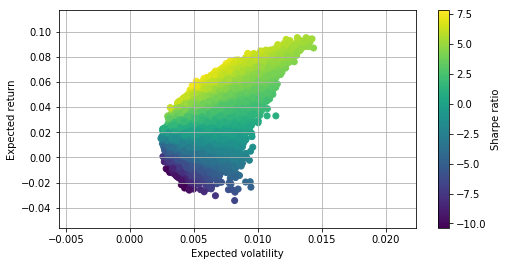

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(8, 4))
plt.scatter(simVols, simRets, c=simSharpes, marker="o")
plt.grid(True)
plt.xlabel("Expected volatility")
plt.ylabel("Expected return")
plt.colorbar(label="Sharpe ratio")
plt.show()

In [17]:
# Get top 10 with lowest volatility
sortedIndices = np.argsort(simVols)[:10]

results = []
for x in sortedIndices:
    results.append(
        np.insert(simWeights[x] * 100000, 0, [simSharpes[x], simRets[x], simVols[x]])
    )
pd.DataFrame(results, columns=["SharpeRatio", "Returns", "Volatility"] + stockNames)

,SharpeRatio,Returns,Volatility,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD
0,-2.054235,0.014999,0.002434,6532.429799,26342.662625,8228.960049,1531.050935,34817.992465,6665.857625,7077.693029,805.549906,7997.803567
1,-1.359242,0.016595,0.002505,3914.764635,24159.682681,3897.622644,871.606516,33594.624971,5090.041474,8299.401446,9128.423058,11043.832574
2,-3.548983,0.010953,0.002549,2113.375478,30832.054440,7910.699386,2609.710928,26255.448956,10779.549095,2580.193006,14933.259788,1985.708921
3,0.651869,0.021669,0.002561,793.857642,23835.267911,4564.379183,1560.865136,36647.011368,9802.799056,5852.304042,2837.052454,14106.463208
4,1.063411,0.022739,0.002576,8218.308897,23729.644116,5744.570512,6364.267847,34151.891722,6878.808200,6574.415075,4311.414321,4026.679310
5,-7.467270,0.000667,0.002589,2428.371283,27804.422370,16539.595553,3650.063382,30475.907934,2055.898933,3462.607038,3059.335938,10523.797569
6,0.164808,0.020429,0.002602,4396.546054,18541.680642,7886.292841,6814.112791,35151.682570,9947.404636,5924.558816,7066.608283,4271.113368
7,-4.366553,0.008433,0.002649,2650.878557,24922.593753,11149.998535,2003.712436,31386.476139,13677.821517,12996.272250,257.710278,954.536535
8,-7.293863,0.000545,0.002667,5216.528930,24288.130588,19973.832302,10719.774410,33638.805330,1988.763367,454.939402,3703.756647,15.469024
9,-2.168502,0.014214,0.002668,11664.751660,22033.519156,8114.960110,3635.564620,29881.388908,657.225165,5560.959355,13689.641749,4761.989277


<IPython.core.display.Javascript object>

In [19]:
# Get top 10 portfolio with highest sharpe
sortedIndices = np.argsort(simSharpes)[-10:]

results = []
for x in sortedIndices:
    results.append(np.insert(simWeights[x], 0, [simSharpes[x], simRets[x], simVols[x]]))
pd.DataFrame(results, columns=["SharpeRatio", "Returns", "Volatility"] + stockNames)

,SharpeRatio,Returns,Volatility,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD
0,7.237690,0.074475,0.007527,0.225838,0.138399,0.006374,0.215340,0.205368,0.145695,0.006166,0.005958,0.050861
1,7.257268,0.068648,0.006703,0.228437,0.136891,0.002021,0.226017,0.217648,0.078797,0.007841,0.056115,0.046235
2,7.276183,0.063339,0.005956,0.117137,0.098774,0.006074,0.137755,0.252079,0.284425,0.054031,0.045756,0.003968
3,7.288153,0.058582,0.005294,0.188261,0.222382,0.013856,0.174254,0.214186,0.137861,0.016948,0.029613,0.002638
4,7.374764,0.062688,0.005788,0.179511,0.196448,0.001625,0.060295,0.232273,0.223548,0.010646,0.001420,0.094233
5,7.384906,0.059256,0.005316,0.185605,0.178984,0.001745,0.119218,0.237039,0.163896,0.009118,0.065734,0.038661
6,7.414611,0.058773,0.005229,0.119018,0.138385,0.017726,0.232613,0.298229,0.091419,0.017705,0.013793,0.071113
7,7.437495,0.059549,0.005318,0.124948,0.144532,0.021068,0.117782,0.272058,0.258715,0.019569,0.016085,0.025244
8,7.596102,0.057052,0.004878,0.095677,0.104792,0.009828,0.067495,0.315492,0.317040,0.022192,0.054019,0.013465
9,7.816351,0.060620,0.005197,0.170605,0.065023,0.004958,0.027937,0.357180,0.281188,0.013112,0.036002,0.043996


<IPython.core.display.Javascript object>

## Future Improvements

- Simulation of 100k scenarios is too slow, consider using genetics algorithm to find minima
- Account for foreign currency conversion rates
- K-fold cross validation to ensure the portfolio works for all market condition
- Backtest portfolio in different market conditions
- Add regular rebalancing into backtest
- Simulated returns of portfolio
- Difference in trading day alter covariance (BTC)